In [1]:
import sys
import os
import numpy as np
import numpy.linalg as la 
import torch
from tqdm import tqdm
import pickle

from ControlRF import GPController, ADPKernel, ADPRandomFeatures, ADKernel, ADRandomFeatures, VanillaKernel, VanillaRandomFeatures
from ControlRF.plots import *
from ControlRF.util import *

from core.controllers import QPController, LQRController, FBLinController
from core.dynamics import AffineQuadCLF
from core.systems import InvertedPendulum, DoubleInvertedPendulum

In [2]:
system_est = DoubleInvertedPendulum(.5,.5,0.8,0.8)
Q , R = 10*np.identity(4), np.identity(2)
lyap_est = AffineQuadCLF.build_care(system_est, Q, R) 
alpha = min(la.eigvalsh(Q)) / max(la.eigvalsh(lyap_est.P))

model_lqr = LQRController.build(system_est, Q, R)
model_fb_lin = FBLinController(system_est, model_lqr)
# fb_lin_data = system.simulate(x_0, fb_lin, ts) #1

qp_controller = QPController.build_care(system_est, Q, R)
qp_controller.add_regularizer(model_fb_lin, 25)
qp_controller.add_static_cost(np.identity(2))
qp_controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e5)
#plot_simulation_dip(system, controller, 'qp_controller', x_0, T=100, num_steps=1000)s

In [3]:
l_1 = 1
l_2 = 1
system = DoubleInvertedPendulum(0.2,0.2,l_1,l_2) 
lyap = AffineQuadCLF.build_care(system, Q, R) 
alpha = min(la.eigvalsh(Q)) / max(la.eigvalsh(lyap.P))

lqr = LQRController.build(system, Q, R)
fb_lin = FBLinController(system, lqr)
oracle_controller = QPController.build_care(system, Q, R)
oracle_controller.add_regularizer(fb_lin, 25)
oracle_controller.add_static_cost(np.identity(2))
oracle_controller.add_stability_constraint(lyap, comp=lambda r: alpha * r, slacked=True, coeff = 1e5)


In [4]:
#create_data(system, qp_controller, lyap_est, 1, 10)
# data = np.load('data,pi,1,sim:10,100.npz')
data = np.load('data/training_data/data_1_10,(10809, 4).npz')
xs = data['xs']
ys = data['ys']
zs = data['zs']

from sklearn.model_selection import train_test_split
xs_train, xs_test, ys_train, ys_test, zs_train, zs_test = train_test_split(xs,ys,zs,test_size=.1,random_state=2)

In [5]:
def dip_train(system_est, lyap_est, xs, ys, zs):
    ad_rf = ADRandomFeatures(xs_train, ys_train, zs_train, rf_d=2000)
    adp_rf = ADPRandomFeatures(xs_train, ys_train, zs_train, rf_d=1500)
    ad_kernel = ADKernel(xs_train, ys_train, zs_train)
    adp_kernel = ADPKernel(xs_train, ys_train, zs_train)
    gps = [ad_kernel, adp_rf, adp_kernel, ad_rf]
    controllers = []
    for gp in gps:
        print(gp.__name__)
        gp_controller = GPController(system_est, gp)
        gp_controller.add_regularizer(fb_lin, 25)
        gp_controller.add_static_cost(np.identity(2))
        if gp.__name__=='adp_kernel':
            time_slack = False
        else:
            time_slack = True
        gp_controller.add_stability_constraint(lyap_est, comp=alpha, slacked=True, time_slack=time_slack, coeff=1e5)
        controllers.append(gp_controller)
        print(f'training time for {gp.__name__}_gp is: {gp.training_time}')
    return controllers, gps

In [6]:
controllers, gps = dip_train(system_est, lyap_est, xs, ys, zs)
# with open('controllers_gps','wb') as f:
#     pickle.dump(gps,f)


ad_kernel
training time for ad_kernel_gp is: 39.19778106396552
adp_rf
training time for adp_rf_gp is: 6.30029550998006
adp_kernel
training time for adp_kernel_gp is: 37.75559561699629
ad_rf
training time for ad_rf_gp is: 1.505492263007909


In [7]:
print(len(zs_test))

1081


In [8]:
from sklearn.metrics import mean_squared_error
for gp in gps:
    zs_pred = gp.test(xs_test, ys_test)
    diff = np.abs(zs_pred-zs_test)
    print(np.sum(np.abs(diff))/len(zs_test))
    print(np.sum(diff<1))
            # print(i,diff[i],zs_test[i], zs_pred[i])
    mse = mean_squared_error(zs_test, zs_pred)
    rmse = mean_squared_error(zs_test, zs_pred, squared = False)
    print(f'{gp.__name__} mse,rmse is {mse,rmse} respectively')


1.1083872191684139
875
ad_kernel mse,rmse is (12.8181130131215, 3.5802392396488676) respectively
1.1636987526995552
834
adp_rf mse,rmse is (12.286841224133894, 3.5052590808860185) respectively
1.108902754553992
876
adp_kernel mse,rmse is (12.807138266131892, 3.578706227972882) respectively
1.216005041036322
842
ad_rf mse,rmse is (13.319889416850048, 3.649642368349267) respectively


In [9]:
# with open('controllers_gps','wb') as f:
#     gps = pickle.load(f)

In [18]:
def plot_c_dot(num,x_0):
    '''plotting true C_dot using specified controller over time'''
    
    c = 1
    fmts = ['c-','m-','y-','r-']


    fig, ax = plt.subplots(sharex=True)
    ax.set_xlabel('$t$', fontsize=8)
    ax.set_ylabel('$C$', fontsize=8)
    

    # data = np.load(f'data/c_dots/{num}.npz')
    data = np.load(f'data/[1,0,0,0]/{num}.npz')
    gp_zs = data['gp_zs']
    qp_zs = data['qp_zs']
    model_zs = data['model_zs']
    ts = data['ts']

    for i,(controller,fmt) in enumerate(zip(controllers,fmts)):
        ax.plot(ts, gp_zs[i], fmt, label=controller.__name__, markersize=c, alpha=.4)

    ax.plot(ts, qp_zs, '-',label='qp_controller', markersize=c)
    ax.plot(ts, model_zs, 'k-.',label='oracle_controller', markersize=c)

    ax.legend()
    plt.figtext(.12,.94,f'x_0={x_0}')
    fig.figsize=(9,6)
    fig.tight_layout()
    fig.savefig(f'data/[1,0,0,0]/{num}_10.png')
    plt.show()
    plt.close()
    
    
    
    fig, ax = plt.subplots(sharex=True)
    ax.set_xlabel('$t$', fontsize=8)
    ax.set_ylabel('$C$', fontsize=8)
    
    for i,(controller,fmt) in enumerate(zip(controllers,fmts)):
        ax.plot(ts[30:50], gp_zs[i,30:50], fmt, label=controller.__name__, markersize=c, alpha=.4)
    ax.plot(ts[30:50], qp_zs[30:50], '-',label='qp_controller', markersize=c)
    ax.plot(ts[30:50], model_zs[30:50], 'k-.',label='oracle_controller', markersize=c)

    ax.legend()
    plt.figtext(.12,.94,f'x_0={x_0}')
    fig.figsize=(9,6)
    fig.tight_layout()
    fig.savefig(f'data/[1,0,0,0]/{num}_3_5.png')
    plt.show()
    
    plt.close()
    

In [16]:
initial_x0s = np.mgrid[-1:1.1:1, -1:1.1:.5, -1:1.1:1, -1:1.1:.5].reshape(4, -1).T
T=10
num_steps=100
ts = np.linspace(0, T, num_steps)


def make_c_dot_data(num, x_0, ts=ts[1:], controllers=controllers, system=system, lyap_est=lyap_est, T=T, 
                    num_steps=num_steps, qp_controller=qp_controller, 
                    oracle_controller=oracle_controller, lyap=lyap):

    gp_zs=np.empty((4,len(ts)))
    for i,controller in enumerate(controllers):
        gp_zs[i,:] = c_dot(system, controller, lyap_est, x_0, T, num_steps)

    qp_zs = c_dot(system, qp_controller, lyap_est, x_0, T, num_steps)
    model_zs = c_dot(system, oracle_controller, lyap, x_0, T, num_steps)
    
    np.savez(f'data/[1,0,0,0]/c_dots_{num}', gp_zs=gp_zs, qp_zs=qp_zs, model_zs=model_zs, ts=ts)
    return None

def make_c_data(num, x_0, ts=ts, controllers=controllers, system=system, lyap_est=lyap_est, T=T, 
                    num_steps=num_steps, qp_controller=qp_controller, 
                    oracle_controller=oracle_controller, lyap=lyap):

    gp_zs=np.empty((4,len(ts)))
    for i,controller in enumerate(controllers):
        gp_xs, _, _ = simulate(system, controller, x_0, T, num_steps)
        gp_zs[i,:] = [lyap_est.eval(gp_xs[i],ts[i]) for i in range(num_steps)]
    
    qp_xs,_ ,_ = simulate(system, qp_controller, x_0, T, num_steps)
    qp_zs = [lyap_est.eval(qp_xs[i],ts[i]) for i in range(num_steps)]
    
    model_xs,_ ,_ = simulate(system, oracle_controller, x_0, T, num_steps)
    model_zs = [lyap.eval(model_xs[i],ts[i]) for i in range(num_steps)]
    
    np.savez(f'data/[1,0,0,0]/c_{num}', gp_zs=gp_zs, qp_zs=qp_zs, model_zs=model_zs, ts=ts)
    return None

In [12]:
# initial_x0s = np.array([[1,0,0,0],[1,0,1,0],[0,0,1,0]])
make_c_data(3,np.array([0,-1,2.8,-.5]))
make_c_dot_data(3,np.array([0,-1,2.8,-.5]))
make_c_data(0,np.array([1,0,0,0]))
make_c_dot_data(0,np.array([1,0,0,0]))
# make_c_data(4,np.array([1,0,2,0]))
# make_c_dot_data(4,np.array([1,0,2,0]))

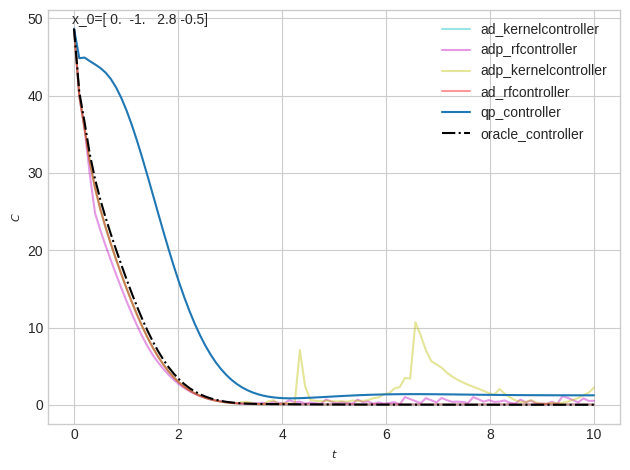

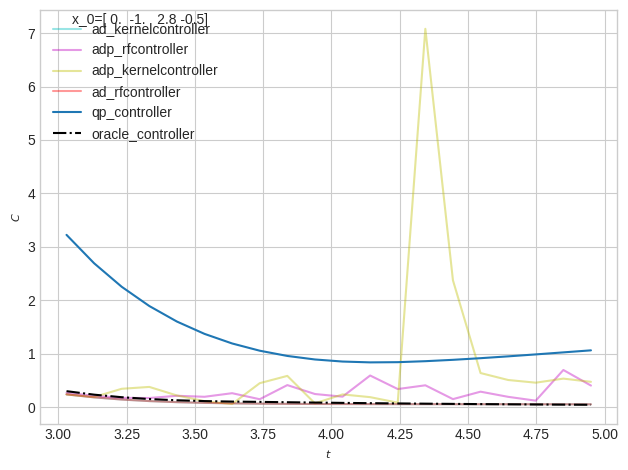

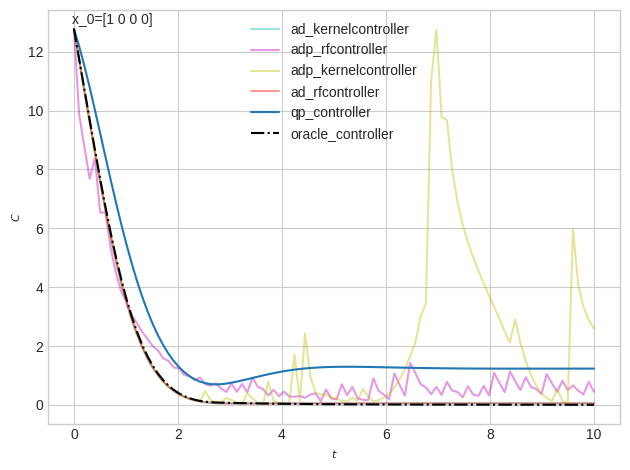

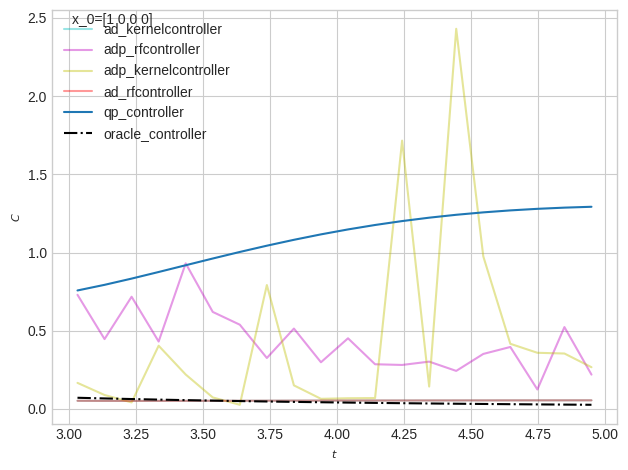

In [19]:
plot_c_dot('c_3',np.array([0,-1,2.8,-.5]))
# plot_c_dot('c_dots_3',np.array([0,-1,2.8,-.5]))
plot_c_dot('c_0',np.array([1,0,0,0]))
# plot_c_dot('c_dots_0',np.array([1,0,0,0]))
# plot_c_dot('c_4',np.array([1,0,2,0]))
# plot_c_dot('c_dots_4',np.array([1,0,2,0]))

In [ ]:
# from multiprocessing import Pool
# with Pool(3) as p:
#     ans = p.starmap(make_c_data, enumerate(initial_x0s))
#     ans2 = p.starmap(make_c_dot_data, enumerate(initial_x0s))

    

In [ ]:
for num,x_0 in tqdm(enumerate(initial_x0s)): 
    if os.path.isfile(f'/home/kk983/random_features/data/c_dots/{num}.npz'):
        plot_c_dot(num,x_0)